# PRÁCTICA 2

## Imports

In [1]:
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.visualization.scatter import Scatter
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import plotly.graph_objects as go

## Problemas

In [2]:
zdt1 = get_problem("zdt1")
zdt3 = get_problem("zdt3")
mw7 = get_problem("mw7",n_var=30)
mw14 = get_problem("mw14",n_var=30)

In [3]:
class TSPProblem(Problem):
    def __init__(self, n_cities: int, seed=50):
        # Define the number of variables (cities) and objectives (time and distance)
        super().__init__(n_var=n_cities, n_obj=2, n_constr=0, xl=0, xu=1)
        
        # Initialize the random seed for reproducibility
        np.random.seed(seed)
        
        # Generate random distances and times between cities
        self.distances = np.random.uniform(0, 100, size=(n_cities, n_cities))
        self.distances = (self.distances + self.distances.T) / 2
        self.times = np.random.uniform(0, 300, size=(n_cities, n_cities))

        # Ensure the diagonal is zero (distance/time from a city to itself is zero)
        np.fill_diagonal(self.distances, 0)
        np.fill_diagonal(self.times, 0)

    def _evaluate(self, x, out, *args, **kwargs):
        # Calculate the total distance and time for each individual in "x" (population)
        distances = []
        times = []
        for route in x:
            perm = np.argsort(route)
            total_distance = 0
            total_time = 0
            
            for i in range(len(perm) - 1):
                total_distance += self.distances[perm[i], perm[i+1]]
                total_time += self.times[perm[i], perm[i+1]]
            
            # Add distance and time from last city back to the first city
            total_distance += self.distances[perm[-1], perm[0]]
            total_time += self.times[perm[-1], perm[0]]
            
            distances.append(total_distance)
            times.append(total_time)
        
        out["F"] = np.column_stack([distances, times])

In [4]:
tsp = TSPProblem(n_cities=100)

## Métricas

In [5]:
from pymoo.indicators.hv import Hypervolume

def metrics_function(pareto_front: np.ndarray[np.ndarray]) -> tuple[float, float, float]:
    """Calculate the hypervolume and epsilon indicators for the final Pareto front."""

    # Calculate the hypervolume indicator
    ref_point=np.array([5000, 14000])
    hv = Hypervolume(ref_point)
    hypervolume = hv.do(pareto_front)

    # SPA metric
    distances = np.linalg.norm(pareto_front[:, None] - pareto_front[None, :], axis=-1)
    SPA = np.mean(np.min(distances + np.diag(np.inf * np.ones(len(distances))), axis=1))

    # dispersion metric
    minimum = np.min(pareto_front, axis=0)
    maximum = np.max(pareto_front, axis=0)
    SPR = np.linalg.norm(maximum - minimum)

    return hypervolume, SPA, SPR 

## Algoritmo evolutivo
### Crossovers

In [6]:
def sbx_crossover(parent1, parent2, problem):
    """
    Apply crossover to a single pair of parents.

    Parameters:
        parent1 (np.ndarray): The first parent.
        parent2 (np.ndarray): The second parent.

    Returns:
        np.ndarray: The offspring pair after crossover.
    """
    eta = 15
    lower_bounds, upper_bounds = problem.bounds()

    u = np.random.rand(len(parent1))
    beta = np.where(u <= 0.5, (2 * u) ** (1 / (eta + 1)), (1 / (2 * (1 - u))) ** (1 / (eta + 1)))
    child1 = 0.5 * ((1 + beta) * parent1 + (1 - beta) * parent2)
    child2 = 0.5 * ((1 - beta) * parent1 + (1 + beta) * parent2)

    child1 = np.clip(child1, lower_bounds, upper_bounds)
    child2 = np.clip(child2, lower_bounds, upper_bounds)

    return child1, child2

### Mutación

In [7]:
def pm_mutate(individual, problem, pmut : int =0.1):
    """
    Perform polynomial mutation on an individual.

    Parameters:
        individual (np.ndarray): The individual to mutate.
        problem (Problem): The problem instance to get the bounds.

    Returns:
        np.ndarray: The mutated individual.
    """
    
    lower_bounds, upper_bounds = problem.bounds()
    mutated_individual = individual.copy()  # Make a copy to avoid modifying the original

    for j in range(len(individual)):  # Iterate over each gene in the individual
        # Polynomial mutation
        if np.random.rand() < pmut:  # Mutation probability
            delta = np.random.uniform(-1, 1)  # This is an example mutation delta
            mutated_individual[j] += delta  # Apply mutation
            mutated_individual[j] = np.clip(mutated_individual[j], lower_bounds[j], upper_bounds[j])  # Clip to bounds

    return mutated_individual

In [8]:
def multi_mutate(individual, problem, pmut : int =0.1):
    """
    Aplica un operador de mutación seleccionado aleatoriamente a un individuo.

    Parameters:
    - ind: Individuo a mutar.
    - pmut: Probabilidad de mutación.

    Returns:
    - Individuo mutado.
    """

    def mutate_uniform(ind, pmut):
        """
        Mutación uniforme: cada gen tiene probabilidad pmut de ser reemplazado
        por un valor aleatorio en los límites del problema.
        """
        for i in range(len(ind)):
            if np.random.rand() < pmut:
                ind[i] = np.random.uniform(problem.xl[i], problem.xu[i])
        return ind

    def mutate_gaussian(ind, pmut, sigma=0.1):
        """
        Mutación gaussiana: con probabilidad pmut, se le suma
        una perturbación normal(0, sigma).
        """
        for i in range(len(ind)):
            if np.random.rand() < pmut:
                # pequeña perturbación
                perturb = np.random.normal(0, sigma)
                ind[i] += perturb
                # recortamos a [0,1]
                ind[i] = np.clip(ind[i], problem.xl[i], problem.xu[i])
        return ind

    mutation_operator = np.random.choice([mutate_uniform, mutate_gaussian])
    return mutation_operator(individual, pmut)

### Selección

In [9]:
def binary_tournament_by_rank_and_crowding(population, fitness, ranks, crowding_distances):
    # Randomly select two individuals for the tournament
    if len(population) < 2:
        indices = np.random.choice(len(population), size=2, replace=True)
    else:
        indices = np.random.choice(len(population), size=2, replace=False)
    
    individual1, individual2 = population[indices]
    fitness1, fitness2 = fitness[indices]

    # Extract additional properties for comparison
    rank1, cd1 = ranks[indices[0]], crowding_distances[indices[0]]
    rank2, cd2 = ranks[indices[1]], crowding_distances[indices[1]]

    if rank1 < rank2:
        return individual1
    elif rank2 < rank1:
        return individual2

    # If rank or domination didn't make a decision, compare by crowding distance
    return (
        individual1 if cd1 > cd2 else individual2 if cd2 > cd1 else (
            individual1 if np.random.rand() < 0.5 else individual2
        )
    )

In [10]:
def multi_binary_tournament_by_rank_and_crowding(population: np.ndarray, fitness: np.ndarray, ranks: np.ndarray, crowding_distances: np.ndarray, T: int = 10) -> np.ndarray:
    """Select an individual from the population using tournament selection based on rank and crowding distance"""
    selected = [binary_tournament_by_rank_and_crowding(population, fitness, ranks, crowding_distances) for _ in range(T)]
    return max(selected, key=lambda ind: ranks[np.where(population == ind)[0][0]])

### Algoritmos

In [11]:
class SoftMajo:
    def __init__(self, problem: Problem, 
                 p_cross = 1, p_mut = 0.1, population_size=100, generations=100, 
                 crossover_method="sbx", mutation_method="pm", 
                 elitism = "Full", selection_method="binary_tournament_by_rank_and_crowding", selection_approach="full_population"):
        
        self.problem = problem
        self.population_size = population_size
        self.generations = generations
        self.selection_approach = selection_approach
        self.elitism = elitism

        self.generations_history = list()
        self.pareto_history = list()

        self.p_cross = p_cross
        self.p_mut = p_mut

        self.crossover_method = crossover_method
        self.mutation_method = mutation_method
        self.selection_method = selection_method

    def initialize_population(self):
        lower_bounds, upper_bounds = self.problem.bounds()
        return np.random.uniform(lower_bounds, upper_bounds, (self.population_size, self.problem.n_var))

    def evaluate_population(self, population):
        return self.problem.evaluate(population, return_values_of=['F'])
        
    def crossover(self, parent1, parent2):
        if(self.crossover_method == "sbx"):
            return sbx_crossover(parent1, parent2, self.problem)
        else:
            raise ValueError("Invalid crossover method")

    def evolve(self, trace: int = 100):
        # Initialize population
        population = self.initialize_population()

        for generation in range(self.generations):
            # Evaluate the population
            fitness = self.evaluate_population(population)

            self.generations_history.append(fitness)
            pareto_front, pareto_fitness = self.calculate_pareto_front(population, fitness)
            self.pareto_history.append(pareto_fitness)
            
            # Compute rank and crowding distance
            self._ranks = self.assign_rank(population, fitness)
            self._crowding_distances = self.assign_crowding_distance(population, fitness)

            new_population = list()

            if(self.elitism == "Full"):
                # Add the pareto front to the new population
                new_population.extend(pareto_front)
            elif(self.elitism == "PartialByDiversity"):
                # Add the best individuals by diversity
                pareto_crowding_distances = self.assign_crowding_distance(pareto_front, pareto_fitness)
                diversity_sorted_indices = np.argsort(pareto_crowding_distances)[::-1]
                num_elites = min(len(pareto_front), self.population_size - len(new_population))
                # print(f"Adding {num_elites} elites")
                new_population.extend(pareto_front[diversity_sorted_indices[:num_elites]])

            while(self.population_size > len(new_population)):
                # Perform selection
                parent1 = self.selection(population, fitness)
                parent2 = self.selection(population, fitness)

                offspring1, offspring2 = parent1, parent2

                if(random.random() < self.p_cross):
                    # Apply crossover
                    offspring1, offspring1 = self.crossover(parent1, parent2)

                offspring1 = self.mutate(offspring1)
                offspring2 = self.mutate(offspring2)

                # Add the individuals to the new population
                new_population.append(offspring1)
                new_population.append(offspring2)

            # plot the trace
            if generation % trace == 0 and generation > 0:
                print(f"Generation {generation}")

            population = np.array(new_population)
            
        # Final evaluation
        final_fitness = self.evaluate_population(population)
        return population, final_fitness
    
    def selection(self, population, fitness):
        """
        Perform the selected selection method using the selected approach.

        Returns:
            np.ndarray: The selected individual.
        """
        if self.selection_approach == "pareto_front":
            selection_population, selection_fitness = self.calculate_pareto_front(population, fitness)
        else:
            selection_population, selection_fitness = population, fitness

        if self.selection_method == "binary_tournament_by_rank_and_crowding":
            return binary_tournament_by_rank_and_crowding(selection_population, selection_fitness, self._ranks, self._crowding_distances)
        elif self.selection_method == "multi_binary_tournament_by_rank_and_crowding":
            return multi_binary_tournament_by_rank_and_crowding(selection_population, selection_fitness, self._ranks, self._crowding_distances, T=10)
        else:
            raise ValueError("Invalid selection method")

    def assign_rank(self, population, fitness):
        """
        Assign non-dominated ranks to the population.
        
        Parameters:
            population (list): The population of individuals.
            fitness (np.ndarray): The fitness values of the population.

        Returns:
            np.ndarray: Array of ranks for the population.
        """
        n = len(population)
        ranks = np.zeros(n, dtype=int)
        domination_count = np.zeros(n, dtype=int)
        dominated_solutions = [[] for _ in range(n)]
        fronts = [[]]

        # Calculate domination relationships
        for i in range(n):
            for j in range(n):
                if np.all(fitness[i] <= fitness[j]) and np.any(fitness[i] < fitness[j]):
                    dominated_solutions[i].append(j)
                elif np.all(fitness[j] <= fitness[i]) and np.any(fitness[j] < fitness[i]):
                    domination_count[i] += 1
            
            if domination_count[i] == 0:  # No one dominates this solution
                ranks[i] = 0
                fronts[0].append(i)
        
        # Generate the fronts
        current_front = 0
        while fronts[current_front]:
            next_front = []
            for i in fronts[current_front]:
                for j in dominated_solutions[i]:
                    domination_count[j] -= 1
                    if domination_count[j] == 0:
                        ranks[j] = current_front + 1
                        next_front.append(j)
            current_front += 1
            fronts.append(next_front)
        
        return ranks
    
    def assign_crowding_distance(self, population, fitness):
        """
        Assign crowding distance to the population.
        
        Parameters:
            population (list): The population of individuals.
            fitness (np.ndarray): The fitness values of the population.

        Returns:
            np.ndarray: Array of crowding distances for the population.
        """
        n, num_objectives = fitness.shape
        distances = np.zeros(n)
        
        for m in range(num_objectives):
            sorted_indices = np.argsort(fitness[:, m])
            min_value = fitness[sorted_indices[0], m]
            max_value = fitness[sorted_indices[-1], m]
            distances[sorted_indices[0]] = distances[sorted_indices[-1]] = np.inf
            
            if max_value > min_value:  # Avoid division by zero
                for i in range(1, n - 1):
                    distances[sorted_indices[i]] += (
                        (fitness[sorted_indices[i + 1], m] - fitness[sorted_indices[i - 1], m]) /
                        (max_value - min_value)
                    )
        
        return distances

    def mutate(self, population):
        if(self.mutation_method == "pm"):
            return pm_mutate(population, self.problem, self.p_mut)
        elif(self.mutation_method == "multi_mutate"):
            return multi_mutate(population, self.problem, self.p_mut)
        else:
            raise ValueError("Invalid mutation method")
        
    def calculate_pareto_front(self, population, fitness):
        """
        Calculate the Pareto front for the given population.

        Parameters:
            population (np.ndarray): The population.
            fitness (np.ndarray): The objective values of the population.

        Returns:
            np.ndarray: The Pareto-optimal solutions.
            np.ndarray: The corresponding objective values of the Pareto front.
        """
        is_pareto = np.ones(fitness.shape[0], dtype=bool)
        for i, f1 in enumerate(fitness):
            if is_pareto[i]:
                is_pareto[is_pareto] = np.any(fitness[is_pareto] < f1, axis=1)
                is_pareto[i] = True
        return population[is_pareto], fitness[is_pareto]
    

In [12]:
class SoftMajoR:
    def __init__(self, problem: Problem, 
                 p_cross = 1, p_mut = 0.1, population_size=100, generations=100, 
                 crossover_method="sbx", mutation_method="pm", 
                 elitism = "Full",
                 selection_method="binary_tournament_by_rank_and_crowding", selection_approach="full_population"):
        """
        Inicializa el algoritmo evolutivo.

        Parámetros:
            problem (Problem): Instancia de un problema de pymoo que define el problema de optimización 
                                multiobjetivo, con sus variables de decisión, restricciones y funciones objetivo.
            
            p_cross (float, opcional): Probabilidad de crossover (cruce) en el algoritmo evolutivo. 
                                        Este valor determina la probabilidad con la que se realizará un cruce 
                                        entre dos padres para generar descendencia. El valor predeterminado es 1, 
                                        lo que significa que siempre se intentará realizar un cruce cuando se 
                                        seleccionen dos padres. 
            
            p_mut (float, opcional): Probabilidad de mutación en el algoritmo evolutivo. 
                                      Este valor determina la probabilidad de aplicar una mutación a un descendiente. 
                                      El valor predeterminado es 0.1, lo que significa que hay un 10% de probabilidad 
                                      de mutación para cada descendiente.

            population_size (int, opcional): Tamaño de la población. Este parámetro controla cuántos individuos 
                                              estarán presentes en la población de cada generación. El valor 
                                              predeterminado es 100.

            generations (int, opcional): Número de generaciones. Especifica la cantidad de iteraciones o 
                                          ciclos que el algoritmo evolucionará. Cada generación implica la 
                                          selección, cruce, mutación y evaluación de individuos en la población. 
                                          El valor predeterminado es 100.

            crossover_method (str, opcional): Método de cruce a utilizar. Define la técnica de cruce utilizada 
                                               para generar la descendencia de dos padres. El valor predeterminado es 
                                               `"sbx"`, que corresponde al cruce basado en SBX (Simulated Binary Crossover).

            mutation_method (str, opcional): Método de mutación a utilizar. Define la técnica de mutación que 
                                              se aplicará a los descendientes. El valor predeterminado es `"pm"`, que 
                                              corresponde a una mutación basada en la probabilidad de mutación por 
                                              punto de variación.

            selection_method (str, opcional): Método de selección a utilizar. Determina cómo se eligen los padres 
                                              para la creación de la descendencia. El valor predeterminado es 
                                              `"tournament_by_rank_and_crowding"`, que corresponde a un torneo de 
                                              selección que toma en cuenta el rango y la distancia de aglomeración 
                                              de los individuos.

            selection_approach (str, opcional): Enfoque de selección a utilizar. Este parámetro especifica si la 
                                                 selección debe realizarse entre toda la población o solo entre los 
                                                 individuos en el frente de Pareto. Puede ser uno de los siguientes valores:
                                                 - `"full_population"`: La selección se realiza entre todos los 
                                                   individuos de la población.
                                                 - `"pareto_front"`: La selección se realiza únicamente entre los 
                                                   individuos que están en el frente de Pareto, es decir, aquellos 
                                                   que son no dominados por otros en términos de sus objetivos.

        """
        self.problem = problem
        self.population_size = population_size
        self.generations = generations
        self.selection_approach = selection_approach
        self.elitism = elitism

        self.generations_history = list()
        self.pareto_history = list()

        self.p_cross = p_cross
        self.p_mut = p_mut

        self.crossover_method = crossover_method
        self.mutation_method = mutation_method
        self.selection_method = selection_method

    def initialize_population(self):
        """
        Initialize the population randomly within the problem bounds.

        Returns:
            np.ndarray: The initial population.
        """
        lower_bounds, upper_bounds = self.problem.bounds()
        return np.random.uniform(lower_bounds, upper_bounds, (self.population_size, self.problem.n_var))

    def evaluate_population(self, population):
        """
        Evaluate the objective values for the given population.

        Parameters:
            population (np.ndarray): The population to evaluate.

        Returns:
            np.ndarray: The objective values of the population.
        """
        return self.problem.evaluate(population, return_values_of=['F','G','H'])
    
        
    def crossover(self, parent1, parent2):
        if(self.crossover_method == "sbx"):
            return sbx_crossover(parent1, parent2, self.problem)
        else:
            raise ValueError("Invalid crossover method")

    def evolve(self):
        """
        Run the evolutionary algorithm.

        Returns:
            np.ndarray: The final population.
            np.ndarray: The final objective values.
        """
        # Initialize population
        population = self.initialize_population()

        for generation in range(self.generations):
            # Evaluate the population
            population=self.survive(population)
            fitness,g,h = self.evaluate_population(population)
            self.generations_history.append(fitness)
            pareto_front, pareto_fitness = self.calculate_pareto_front(population, fitness)
            self.pareto_history.append(pareto_fitness)
            
            # Compute rank and crowding distance
            self._ranks = self.assign_rank(population, fitness)
            self._crowding_distances = self.assign_crowding_distance(population, fitness)

            new_population = list()

            if(self.elitism == "Full"):
                # Add the pareto front to the new population
                new_population.extend(pareto_front)
            elif(self.elitism == "PartialByDiversity"):
                # Add the best individuals by diversity
                pareto_crowding_distances = self.assign_crowding_distance(pareto_front, pareto_fitness)
                diversity_sorted_indices = np.argsort(pareto_crowding_distances)[::-1]
                num_elites = min(len(pareto_front), self.population_size - len(new_population))
                # print(f"Adding {num_elites} elites")
                new_population.extend(pareto_front[diversity_sorted_indices[:num_elites]])

            while(self.population_size > len(new_population)):
                # Perform selection
                parent1 = self.selection(population, fitness)
                parent2 = self.selection(population, fitness)

                offspring1, offspring2 = parent1, parent2

                if(random.random() < self.p_cross):
                    # Apply crossover
                    offspring1, offspring1 = self.crossover(parent1, parent2)

                offspring1 = self.mutate(offspring1)
                offspring2 = self.mutate(offspring2)

                # Add the individuals to the new population
                new_population.append(offspring1)
                new_population.append(offspring2)

            population = np.array(new_population)
            
        # Final evaluation
        final_fitness,g,h = self.evaluate_population(population)
        return population, final_fitness
    
    def selection(self, population, fitness):
        """
        Perform the selected selection method using the selected approach.

        Returns:
            np.ndarray: The selected individual.
        """
        if self.selection_approach == "pareto_front":
            selection_population, selection_fitness = self.calculate_pareto_front(population, fitness)
        else:
            selection_population, selection_fitness = population, fitness
        
        if self.selection_method == "binary_tournament_by_rank_and_crowding":
            return binary_tournament_by_rank_and_crowding(selection_population, selection_fitness, self._ranks, self._crowding_distances)
        elif self.selection_method == "multi_binary_tournament_by_rank_and_crowding":
            return multi_binary_tournament_by_rank_and_crowding(selection_population, selection_fitness, self._ranks, self._crowding_distances, T = 10)
        else:
            raise ValueError("Invalid selection method")

    def assign_rank(self, population, fitness):
        """
        Assign non-dominated ranks to the population.
        
        Parameters:
            population (list): The population of individuals.
            fitness (np.ndarray): The fitness values of the population.

        Returns:
            np.ndarray: Array of ranks for the population.
        """
        n = len(population)
        ranks = np.zeros(n, dtype=int)
        domination_count = np.zeros(n, dtype=int)
        dominated_solutions = [[] for _ in range(n)]
        fronts = [[]]

        # Calculate domination relationships
        for i in range(n):
            for j in range(n):
                if np.all(fitness[i] <= fitness[j]) and np.any(fitness[i] < fitness[j]):
                    dominated_solutions[i].append(j)
                elif np.all(fitness[j] <= fitness[i]) and np.any(fitness[j] < fitness[i]):
                    domination_count[i] += 1
            
            if domination_count[i] == 0:  # No one dominates this solution
                ranks[i] = 0
                fronts[0].append(i)
        
        # Generate the fronts
        current_front = 0
        while fronts[current_front]:
            next_front = []
            for i in fronts[current_front]:
                for j in dominated_solutions[i]:
                    domination_count[j] -= 1
                    if domination_count[j] == 0:
                        ranks[j] = current_front + 1
                        next_front.append(j)
            current_front += 1
            fronts.append(next_front)
        
        return ranks
    
    def assign_crowding_distance(self, population, fitness):
        """
        Assign crowding distance to the population.
        
        Parameters:
            population (list): The population of individuals.
            fitness (np.ndarray): The fitness values of the population.

        Returns:
            np.ndarray: Array of crowding distances for the population.
        """
        n, num_objectives = fitness.shape
        distances = np.zeros(n)
        
        for m in range(num_objectives):
            sorted_indices = np.argsort(fitness[:, m])
            min_value = fitness[sorted_indices[0], m]
            max_value = fitness[sorted_indices[-1], m]
            distances[sorted_indices[0]] = distances[sorted_indices[-1]] = np.inf
            
            if max_value > min_value:  # Avoid division by zero
                for i in range(1, n - 1):
                    distances[sorted_indices[i]] += (
                        (fitness[sorted_indices[i + 1], m] - fitness[sorted_indices[i - 1], m]) /
                        (max_value - min_value)
                    )
        
        return distances

    def mutate(self, population):
        if(self.mutation_method == "pm"):
            return pm_mutate(population, self.problem, self.p_mut)
        elif(self.mutation_method == "multi_mutate"):
            return multi_mutate(population, self.problem, self.p_mut)
        else:
            raise ValueError("Invalid mutation method")
        
    def calculate_pareto_front(self, population, fitness):
        """
        Calculate the Pareto front for the given population.

        Parameters:
            population (np.ndarray): The population.
            fitness (np.ndarray): The objective values of the population.

        Returns:
            np.ndarray: The Pareto-optimal solutions.
            np.ndarray: The corresponding objective values of the Pareto front.
        """
        is_pareto = np.ones(fitness.shape[0], dtype=bool)
        for i, f1 in enumerate(fitness):
            if is_pareto[i]:
                is_pareto[is_pareto] = np.any(fitness[is_pareto] < f1, axis=1)
                is_pareto[i] = True
        return population[is_pareto], fitness[is_pareto]
        
    def survive(self,pop,*args,**kwargs):
        n_survive = min(0, len(pop))
        F,G,H=self.evaluate_population(pop)
        CV=[]
        tol=1e-6
        if len(G[0])==2:
                boolean=True
        else:
            boolean=False
        for idx in range(len(pop)):
            vio=True
            if G[idx][0]<0:
                vio=False
            if boolean:
                if G[idx][1]>0:
                    vio=False
            CV.append(vio)
    
            
        # feasible_inequalities = np.all(G <= 0, axis=1)  # Inequality constraints satisfied
        # feasible_equalities = np.all(np.abs(H) <= tol, axis=1)  # Equality constraints satisfied

        # # Combine feasibility
        # b = feasible_inequalities & feasible_equalities 

        # feasible = np.where(b)[0]
        # infeasible = np.where(~b)[0]
        CV=np.array(CV)

        # print(CV)


        # infeasible = infeasible[np.argsort(CV[infeasible, 0])]

        return pop[CV]

### Visualizaciones

In [13]:
def plot_comparison(solution: np.ndarray, ngsa2_solution, problem, save_path: str) -> None:
    """Compare Pareto Fronts in a plot"""
    if problem.n_obj == 2:
        fig = plt.figure(figsize=(7, 5))
        ax = fig.add_subplot(1,1,1)

        if hasattr(problem, 'pareto_front') and callable(getattr(problem, 'pareto_front', None)):
            pf = problem.pareto_front()
            if pf is not None:
                ax.scatter(pf[:, 0], pf[:, 1], color='blue', marker='o', label="Original PF")
        ax.scatter(ngsa2_solution.F[:, 0], ngsa2_solution.F[:, 1], color='red', facecolor='none', marker='o', label="NSGA-II solution")
        ax.scatter(solution[:, 0], solution[:, 1], c='green', marker="*", label="Custom solution")
        ax.set_xlabel('Total Distance')
        ax.set_ylabel('Total Time')
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(save_path)
        plt.show()
    else:
        fig = go.Figure()
        
        if hasattr(problem, 'pareto_front') and callable(getattr(problem, 'pareto_front', None)):
            pf = problem.pareto_front()
            if pf is not None:
                fig.add_trace(go.Scatter3d(
                    x=pf[:, 0], y=pf[:, 1], z=pf[:, 2],
                    mode='markers',
                    marker=dict(size=5, color='blue'),
                    name='Original PF'
                ))

        if ngsa2_solution is not None:
            fig.add_trace(go.Scatter3d(
                x=ngsa2_solution.F[:, 0], y=ngsa2_solution.F[:, 1], z=ngsa2_solution.F[:, 2],
                mode='markers',
                marker=dict(size=5, color='red'),
                name='NSGA-II PF'
            ))

        fig.add_trace(go.Scatter3d(
            x=solution[:, 0], y=solution[:, 1], z=solution[:, 2],
            mode='markers',
            marker=dict(size=5, color='green'),
            name='Solution PF'
        ))

        fig.update_layout(
            scene=dict(
                xaxis=dict(title='f1', range=[0, 1.6], autorange=False),
                yaxis=dict(title='f2', range=[0, 1.6], autorange=False),
                aspectmode='cube'
            ),
            legend=dict(x=0, y=1),
            width=800,
            height=600
        )
        fig.show()

In [14]:
def plot_pareto_front_animation(generations_data: list[np.ndarray], ngsa2_solution, save_path: str, interval=500):
    """Save GIF from the historical Pareto Front"""
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel("f1")
    ax.set_ylabel("f2")

    def update(frame):
        ax.clear()
        ax.set_title(f"Generation {frame + 1}")
        solution = generations_data[frame]

        ax.scatter(ngsa2_solution.F[:, 0], ngsa2_solution.F[:, 1], color='blue', marker='x', label="NSGA-II 1000 gen")
        ax.scatter(solution[:, 0], solution[:, 1], c='green', marker="*", label="Custom solution")
        ax.legend(loc='upper right')

    ani = FuncAnimation(fig, update, frames=len(generations_data), interval=interval)
    ani.save(save_path, writer='pillow')
    print(f"Animation saved to {save_path}")

## Resolución de problemas
### ZDT-1

*******Tiempo evolución: 0 minutos y 6.14 segundos*******


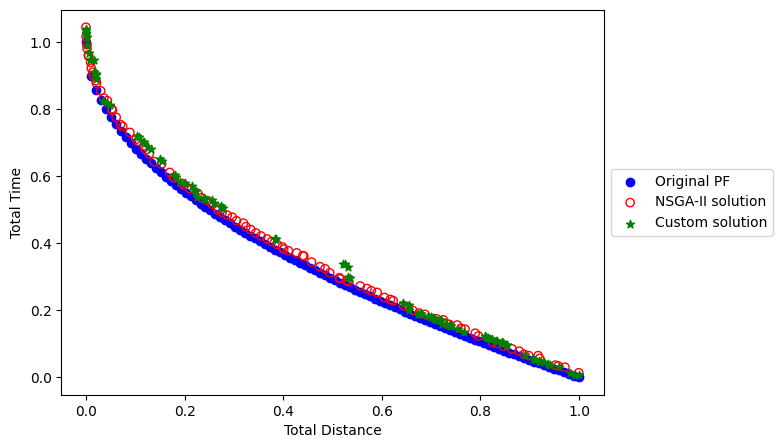

In [15]:
ngsa2_zdt1 = minimize(zdt1, algorithm=NSGA2(pop_size=100), termination=('n_gen', 100))

start = time.time()
ea_zdt1 = SoftMajo(zdt1, p_cross=0.9, p_mut=0.05, population_size=100, generations=100, 
              crossover_method="sbx", mutation_method="pm", selection_method="multi_binary_tournament_by_rank_and_crowding",
              elitism="PartialByDiversity", selection_approach="pareto_front")
final_population, final_fitness = ea_zdt1.evolve()

minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")

pareto_population, pareto_fitness = ea_zdt1.calculate_pareto_front(final_population, final_fitness)
plot_comparison(pareto_fitness, ngsa2_zdt1, zdt1, save_path="MOO-ZDT1-pareto.png")

### ZDT-3

*******Tiempo evolución: 0 minutos y 6.53 segundos*******


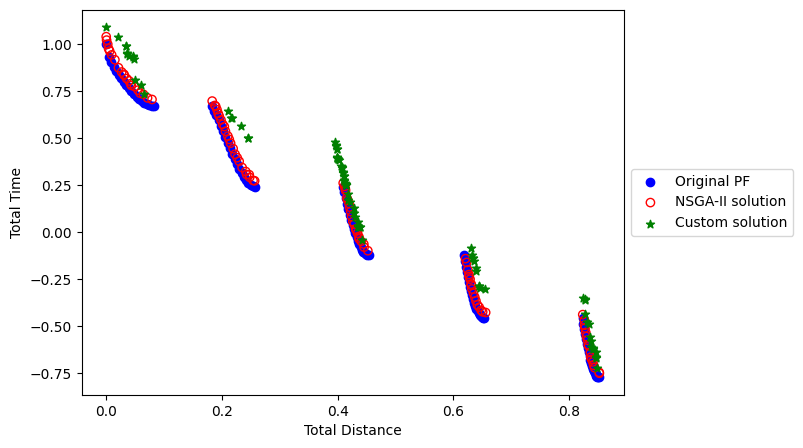

In [16]:
ngsa2_zdt3 = minimize(zdt3, algorithm=NSGA2(pop_size=100), termination=('n_gen', 100))

start = time.time()
ea_zdt3 = SoftMajo(zdt3, p_cross=0.9, p_mut=0.05, population_size=100, generations=100, 
              crossover_method="sbx", mutation_method="pm", selection_method="multi_binary_tournament_by_rank_and_crowding",
              elitism="PartialByDiversity", selection_approach="pareto_front")
final_population, final_fitness = ea_zdt3.evolve()

minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")

pareto_population, pareto_fitness = ea_zdt3.calculate_pareto_front(final_population, final_fitness)
plot_comparison(pareto_fitness, ngsa2_zdt3, zdt3, save_path="MOO-ZDT3-pareto.png")

### MW7

*******Tiempo evolución: 0 minutos y 6.62 segundos*******


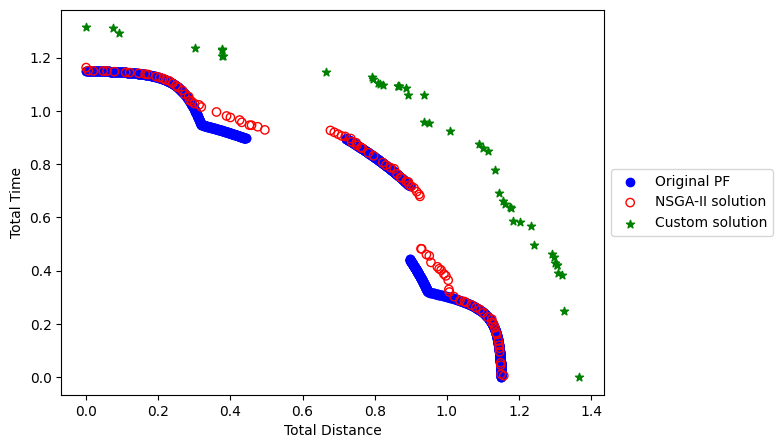

In [17]:
ngsa2_mw7 = minimize(mw7, algorithm=NSGA2(pop_size=100), termination=('n_gen', 100))

start = time.time()
ea_mw7 = SoftMajo(mw7, p_cross=0.9, p_mut=0.05, population_size=100, generations=100, 
              crossover_method="sbx", mutation_method="pm", selection_method="multi_binary_tournament_by_rank_and_crowding",
              elitism="PartialByDiversity", selection_approach="pareto_front")
final_population, final_fitness = ea_mw7.evolve()

minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")

pareto_population, pareto_fitness = ea_mw7.calculate_pareto_front(final_population, final_fitness)
plot_comparison(pareto_fitness, ngsa2_mw7, mw7, save_path="MOO-MW7-pareto.png")

### MW14

In [18]:
ngsa2_mw14 = minimize(mw14, algorithm=NSGA2(pop_size=100), termination=('n_gen', 100))

start = time.time()
ea_mw14 = SoftMajo(mw14, p_cross=0.9, p_mut=0.05, population_size=100, generations=100, 
              crossover_method="sbx", mutation_method="pm", selection_method="multi_binary_tournament_by_rank_and_crowding",
              elitism="PartialByDiversity", selection_approach="pareto_front")
final_population, final_fitness = ea_mw14.evolve()

minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")

pareto_population, pareto_fitness = ea_mw14.calculate_pareto_front(final_population, final_fitness)
plot_comparison(pareto_fitness, ngsa2_mw14, mw14, save_path="MOO-MW14-pareto.png")

*******Tiempo evolución: 0 minutos y 4.64 segundos*******


### TSP

Generation 100
Generation 200
Generation 300
Generation 400
Generation 500
Generation 600
Generation 700
Generation 800
Generation 900
*******Tiempo evolución: 1 minutos y 17.48 segundos*******


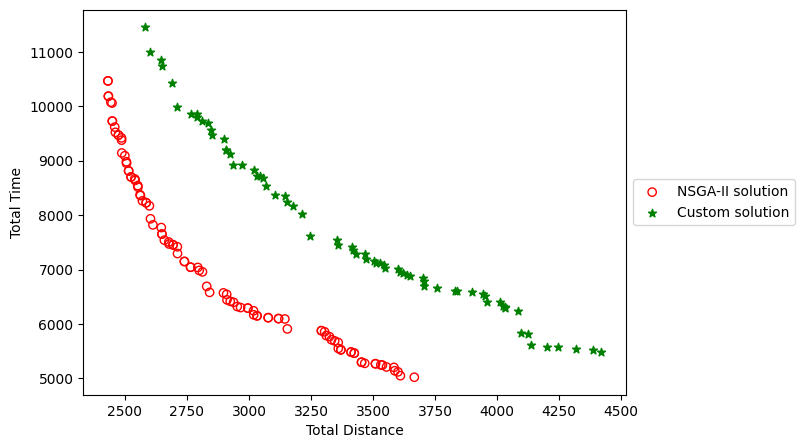

Hypervolume Custom: 16754683.501775708
SPR Custom: 6247.4077137946015
SPA Custom: 63.71771850106344


In [19]:
ngsa2_tsp = minimize(tsp, algorithm=NSGA2(pop_size=100), termination=('n_gen', 1000))

start = time.time()
ea_tsp = SoftMajo(tsp, p_cross=0.92, p_mut=0.01, population_size=100, generations=1000, 
              crossover_method="sbx", mutation_method="pm", selection_method="multi_binary_tournament_by_rank_and_crowding",
              elitism="PartialByDiversity", selection_approach="pareto_front")
final_population, final_fitness = ea_tsp.evolve()

minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")

pareto_population, pareto_fitness = ea_tsp.calculate_pareto_front(final_population, final_fitness)
plot_comparison(pareto_fitness, ngsa2_tsp, tsp, save_path="MOO-TSP-pareto.png")

hv, spa, spr = metrics_function(pareto_fitness)
print(f"Hypervolume Custom: {hv}")
print(f"SPR Custom: {spr}")
print(f"SPA Custom: {spa}")

#### Optimización de parámetros

In [30]:
from itertools import product
from tqdm import tqdm
import csv

def grid_search(problem, param_grid, n_runs):
    results = []

    # Generate all combinations of parameters
    param_combinations = list(product(*param_grid.values()))

    # Filter combinations where generations * population_size != 100000
    valid_combinations = [params for params in param_combinations if params[2] * params[3] == 100000]
    print(f"Valid combinations: {len(valid_combinations)}")

    for params in tqdm(valid_combinations, desc="Parameter Combinations"):
        hv_values = []
        spa_values = []
        spr_values = []

        for _ in tqdm(range(n_runs), desc="Runs", leave=False):

            ea = SoftMajo(problem, 
                          p_cross=params[0], 
                          p_mut=params[1], 
                          population_size=params[2], 
                          generations=params[3], 
                          crossover_method=params[4], 
                          mutation_method=params[5], 
                          selection_method=params[6], 
                          elitism=params[7], 
                          selection_approach=params[8])
            
            final_population, final_fitness = ea.evolve(trace=100000000)
            pareto_population, pareto_fitness = ea.calculate_pareto_front(final_population, final_fitness)
            hv, spa, spr = metrics_function(pareto_fitness)
            
            hv_values.append(hv)
            spa_values.append(spa)
            spr_values.append(spr)

        # Calculate mean and std for each metric
        hv_mean, hv_std = np.mean(hv_values), np.std(hv_values)
        spa_mean, spa_std = np.mean(spa_values), np.std(spa_values)
        spr_mean, spr_std = np.mean(spr_values), np.std(spr_values)

        results.append({
            'params': params,
            'hv_mean': hv_mean,
            'hv_std': hv_std,
            'spa_mean': spa_mean,
            'spa_std': spa_std,
            'spr_mean': spr_mean,
            'spr_std': spr_std
        })

    return results

# Define the parameter grid
param_grid = {
    'p_cross': [0.8, 0.9],
    'p_mut': [0.01, 0.05],
    'population_size': [100, 200],
    'generations': [500, 1000],
    'crossover_method': ['sbx'],
    'mutation_method': ['pm', 'multi_mutate'],
    'selection_method': ['binary_tournament_by_rank_and_crowding', 'multi_binary_tournament_by_rank_and_crowding'],
    'elitism': ['PartialByDiversity'],
    'selection_approach': ['pareto_front']
}

# Run the grid search
n_runs = 10
results = grid_search(tsp, param_grid, n_runs)

# Find the best result by hypervolume, spa, and spr
best_hv_result = max(results, key=lambda x: x['hv_mean'])
best_spa_result = min(results, key=lambda x: x['spa_mean'])
best_spr_result = min(results, key=lambda x: x['spr_mean'])

print("Best result by hypervolume:")
print(best_hv_result)

print("\nBest result by spa:")
print(best_spa_result)

print("\nBest result by spr:")
print(best_spr_result)

# Save the results to a CSV file
csv_file = "grid_search_results.csv"
csv_columns = ['p_cross', 'p_mut', 'population_size', 'generations', 'crossover_method', 'mutation_method', 'selection_method', 'elitism', 'selection_approach', 'hv_mean', 'hv_std', 'spa_mean', 'spa_std', 'spr_mean', 'spr_std']

with open(csv_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=csv_columns)
    writer.writeheader()
    for result in results:
        row = {
            'p_cross': result['params'][0],
            'p_mut': result['params'][1],
            'population_size': result['params'][2],
            'generations': result['params'][3],
            'crossover_method': result['params'][4],
            'mutation_method': result['params'][5],
            'selection_method': result['params'][6],
            'elitism': result['params'][7],
            'selection_approach': result['params'][8],
            'hv_mean': result['hv_mean'],
            'hv_std': result['hv_std'],
            'spa_mean': result['spa_mean'],
            'spa_std': result['spa_std'],
            'spr_mean': result['spr_mean'],
            'spr_std': result['spr_std']
        }
        writer.writerow(row)

print(f"Results saved to {csv_file}")

Valid combinations: 32


Parameter Combinations:   0%|          | 0/32 [00:00<?, ?it/s]

Running with params: p_cross=0.8, p_mut=0.01, population_size=100, generations=1000, crossover_method=sbx, mutation_method=pm, selection_method=binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:   3%|▎         | 1/32 [10:38<5:30:05, 638.88s/it]

Running with params: p_cross=0.8, p_mut=0.01, population_size=100, generations=1000, crossover_method=sbx, mutation_method=pm, selection_method=multi_binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:   6%|▋         | 2/32 [23:04<5:50:46, 701.54s/it]

Running with params: p_cross=0.8, p_mut=0.01, population_size=100, generations=1000, crossover_method=sbx, mutation_method=multi_mutate, selection_method=binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:   9%|▉         | 3/32 [33:32<5:22:54, 668.08s/it]

Running with params: p_cross=0.8, p_mut=0.01, population_size=100, generations=1000, crossover_method=sbx, mutation_method=multi_mutate, selection_method=multi_binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  12%|█▎        | 4/32 [45:51<5:24:52, 696.17s/it]

Running with params: p_cross=0.8, p_mut=0.01, population_size=200, generations=500, crossover_method=sbx, mutation_method=pm, selection_method=binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  16%|█▌        | 5/32 [1:05:40<6:33:09, 873.69s/it]

Running with params: p_cross=0.8, p_mut=0.01, population_size=200, generations=500, crossover_method=sbx, mutation_method=pm, selection_method=multi_binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  19%|█▉        | 6/32 [1:27:58<7:27:00, 1031.54s/it]

Running with params: p_cross=0.8, p_mut=0.01, population_size=200, generations=500, crossover_method=sbx, mutation_method=multi_mutate, selection_method=binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  22%|██▏       | 7/32 [1:47:47<7:31:17, 1083.10s/it]

Running with params: p_cross=0.8, p_mut=0.01, population_size=200, generations=500, crossover_method=sbx, mutation_method=multi_mutate, selection_method=multi_binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  25%|██▌       | 8/32 [2:10:22<7:47:53, 1169.73s/it]

Running with params: p_cross=0.8, p_mut=0.05, population_size=100, generations=1000, crossover_method=sbx, mutation_method=pm, selection_method=binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  28%|██▊       | 9/32 [2:21:11<6:25:57, 1006.83s/it]

Running with params: p_cross=0.8, p_mut=0.05, population_size=100, generations=1000, crossover_method=sbx, mutation_method=pm, selection_method=multi_binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  31%|███▏      | 10/32 [2:34:02<5:42:33, 934.24s/it]

Running with params: p_cross=0.8, p_mut=0.05, population_size=100, generations=1000, crossover_method=sbx, mutation_method=multi_mutate, selection_method=binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  34%|███▍      | 11/32 [2:44:49<4:56:12, 846.32s/it]

Running with params: p_cross=0.8, p_mut=0.05, population_size=100, generations=1000, crossover_method=sbx, mutation_method=multi_mutate, selection_method=multi_binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  38%|███▊      | 12/32 [2:57:31<4:33:29, 820.47s/it]

Running with params: p_cross=0.8, p_mut=0.05, population_size=200, generations=500, crossover_method=sbx, mutation_method=pm, selection_method=binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  41%|████      | 13/32 [3:16:44<4:51:42, 921.20s/it]

Running with params: p_cross=0.8, p_mut=0.05, population_size=200, generations=500, crossover_method=sbx, mutation_method=pm, selection_method=multi_binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  44%|████▍     | 14/32 [3:38:25<5:10:46, 1035.94s/it]

Running with params: p_cross=0.8, p_mut=0.05, population_size=200, generations=500, crossover_method=sbx, mutation_method=multi_mutate, selection_method=binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  47%|████▋     | 15/32 [3:57:42<5:03:50, 1072.39s/it]

Running with params: p_cross=0.8, p_mut=0.05, population_size=200, generations=500, crossover_method=sbx, mutation_method=multi_mutate, selection_method=multi_binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  50%|█████     | 16/32 [4:19:37<5:05:26, 1145.39s/it]

Running with params: p_cross=0.9, p_mut=0.01, population_size=100, generations=1000, crossover_method=sbx, mutation_method=pm, selection_method=binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  53%|█████▎    | 17/32 [4:30:12<4:07:58, 991.93s/it] 

Running with params: p_cross=0.9, p_mut=0.01, population_size=100, generations=1000, crossover_method=sbx, mutation_method=pm, selection_method=multi_binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  56%|█████▋    | 18/32 [4:42:35<3:34:01, 917.23s/it]

Running with params: p_cross=0.9, p_mut=0.01, population_size=100, generations=1000, crossover_method=sbx, mutation_method=multi_mutate, selection_method=binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  59%|█████▉    | 19/32 [4:53:01<2:59:44, 829.61s/it]

Running with params: p_cross=0.9, p_mut=0.01, population_size=100, generations=1000, crossover_method=sbx, mutation_method=multi_mutate, selection_method=multi_binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  62%|██████▎   | 20/32 [5:05:16<2:40:15, 801.29s/it]

Running with params: p_cross=0.9, p_mut=0.01, population_size=200, generations=500, crossover_method=sbx, mutation_method=pm, selection_method=binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  66%|██████▌   | 21/32 [5:25:01<2:48:00, 916.43s/it]

Running with params: p_cross=0.9, p_mut=0.01, population_size=200, generations=500, crossover_method=sbx, mutation_method=pm, selection_method=multi_binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  69%|██████▉   | 22/32 [5:47:15<2:53:37, 1041.75s/it]

Running with params: p_cross=0.9, p_mut=0.01, population_size=200, generations=500, crossover_method=sbx, mutation_method=multi_mutate, selection_method=binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  72%|███████▏  | 23/32 [6:07:06<2:43:00, 1086.68s/it]

Running with params: p_cross=0.9, p_mut=0.01, population_size=200, generations=500, crossover_method=sbx, mutation_method=multi_mutate, selection_method=multi_binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  75%|███████▌  | 24/32 [6:29:32<2:35:16, 1164.58s/it]

Running with params: p_cross=0.9, p_mut=0.05, population_size=100, generations=1000, crossover_method=sbx, mutation_method=pm, selection_method=binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  78%|███████▊  | 25/32 [6:40:21<1:57:47, 1009.61s/it]

Running with params: p_cross=0.9, p_mut=0.05, population_size=100, generations=1000, crossover_method=sbx, mutation_method=pm, selection_method=multi_binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  81%|████████▏ | 26/32 [6:53:10<1:33:45, 937.56s/it] 

Running with params: p_cross=0.9, p_mut=0.05, population_size=100, generations=1000, crossover_method=sbx, mutation_method=multi_mutate, selection_method=binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  84%|████████▍ | 27/32 [7:03:58<1:10:53, 850.61s/it]

Running with params: p_cross=0.9, p_mut=0.05, population_size=100, generations=1000, crossover_method=sbx, mutation_method=multi_mutate, selection_method=multi_binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  88%|████████▊ | 28/32 [7:16:40<54:56, 824.20s/it]  

Running with params: p_cross=0.9, p_mut=0.05, population_size=200, generations=500, crossover_method=sbx, mutation_method=pm, selection_method=binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  91%|█████████ | 29/32 [7:35:53<46:08, 922.73s/it]

Running with params: p_cross=0.9, p_mut=0.05, population_size=200, generations=500, crossover_method=sbx, mutation_method=pm, selection_method=multi_binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  94%|█████████▍| 30/32 [7:57:35<34:32, 1036.43s/it]

Running with params: p_cross=0.9, p_mut=0.05, population_size=200, generations=500, crossover_method=sbx, mutation_method=multi_mutate, selection_method=binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations:  97%|█████████▋| 31/32 [8:17:00<17:55, 1075.02s/it]

Running with params: p_cross=0.9, p_mut=0.05, population_size=200, generations=500, crossover_method=sbx, mutation_method=multi_mutate, selection_method=multi_binary_tournament_by_rank_and_crowding, elitism=PartialByDiversity, selection_approach=pareto_front


Run 1/10


Run 2/10


Run 3/10


Run 4/10


Run 5/10


Run 6/10


Run 7/10


Run 8/10


Run 9/10


Run 10/10


Parameter Combinations: 100%|██████████| 32/32 [8:38:55<00:00, 972.99s/it] 

Best result by hypervolume:
{'params': (0.8, 0.01, 200, 500, 'sbx', 'multi_mutate', 'binary_tournament_by_rank_and_crowding', 'PartialByDiversity', 'pareto_front'), 'hv_mean': np.float64(19414319.87855975), 'hv_std': np.float64(1019366.7903178026), 'spa_mean': np.float64(69.7937046379663), 'spa_std': np.float64(15.239174327328305), 'spr_mean': np.float64(6956.440002732757), 'spr_std': np.float64(636.0213403247475)}

Best result by spa:
{'params': (0.8, 0.01, 100, 1000, 'sbx', 'multi_mutate', 'binary_tournament_by_rank_and_crowding', 'PartialByDiversity', 'pareto_front'), 'hv_mean': np.float64(18072416.927629028), 'hv_std': np.float64(1238051.3506826889), 'spa_mean': np.float64(66.57913856371485), 'spa_std': np.float64(13.223604233043025), 'spr_mean': np.float64(6975.391682630938), 'spr_std': np.float64(1156.0481052477112)}

Best result by spr:
{'params': (0.9, 0.05, 200, 500, 'sbx', 'pm', 'multi_binary_tournament_by_rank_and_crowding', 'PartialByDiversity', 'pareto_front'), 'hv_mean': 

In [32]:
print(len(results))

32


In [33]:
# Find the best result by hypervolume, spa, and spr
best_hv_result = max(results, key=lambda x: x['hv_mean'])
best_spa_result = min(results, key=lambda x: x['spa_mean'])
best_spr_result = min(results, key=lambda x: x['spr_mean'])

print("Best result by hypervolume:")
print(best_hv_result)

print("\nBest result by spa:")
print(best_spa_result)

print("\nBest result by spr:")
print(best_spr_result)

Best result by hypervolume:
{'params': (0.8, 0.01, 200, 500, 'sbx', 'multi_mutate', 'binary_tournament_by_rank_and_crowding', 'PartialByDiversity', 'pareto_front'), 'hv_mean': np.float64(19414319.87855975), 'hv_std': np.float64(1019366.7903178026), 'spa_mean': np.float64(69.7937046379663), 'spa_std': np.float64(15.239174327328305), 'spr_mean': np.float64(6956.440002732757), 'spr_std': np.float64(636.0213403247475)}

Best result by spa:
{'params': (0.8, 0.01, 100, 1000, 'sbx', 'multi_mutate', 'binary_tournament_by_rank_and_crowding', 'PartialByDiversity', 'pareto_front'), 'hv_mean': np.float64(18072416.927629028), 'hv_std': np.float64(1238051.3506826889), 'spa_mean': np.float64(66.57913856371485), 'spa_std': np.float64(13.223604233043025), 'spr_mean': np.float64(6975.391682630938), 'spr_std': np.float64(1156.0481052477112)}

Best result by spr:
{'params': (0.9, 0.05, 200, 500, 'sbx', 'pm', 'multi_binary_tournament_by_rank_and_crowding', 'PartialByDiversity', 'pareto_front'), 'hv_mean': 